## Functionality to Analyze Out of Sample Residuals Using XGBoost

#### Import Packages

In [1]:
import datetime
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import pandas as pd
import sklearn
from sklearn import datasets
import time
import xgboost as xgb
plt.rcParams['figure.figsize'] = [12, 8]

#### Load and Format Example Data

In [2]:
wine = datasets.load_wine()
x_colnames = wine.feature_names
model_data = pd.DataFrame(wine.data, columns = x_colnames)
model_data['y'] = list(wine.target)
model_data = model_data[model_data['y'].isin([0,1])]
model_data = model_data.rename(columns = {'alcohol' : 'alcohol_over_13', 'magnesium' : 'magnesium_over_100'})
model_data['alcohol_over_13'] = [1 if x > 13 else 0 for x in model_data['alcohol_over_13']]
model_data['magnesium_over_100'] = [1 if x > 100 else 0 for x in model_data['magnesium_over_100']]

#### Define Functions & Classes

In [3]:
def print_timestamp_message(message, timestamp_format = '%Y-%m-%d %H:%M:%S'):
    """
    Print formatted timestamp followed by custom message
    Args:
        message (str): string to concatenate with timestamp
        timestamp_format (str): format for datetime string. defaults to '%Y-%m-%d %H:%M:%S'
    """
    ts_string = datetime.datetime.fromtimestamp(time.time()).strftime(timestamp_format)
    print(f'{ts_string}: {message}')
    

def unnest_list(input_list : list):
    """Unnest list of lists"""
    return list(itertools.chain.from_iterable(input_list))


def index_slice_list(lst, indices):
    """Slice list by list of indices"""
    list_slice = operator.itemgetter(*indices)(lst)
    if len(indices) == 1:
        return [list_slice]
    else:
        return list(list_slice)
    

class ScarceValueReplacement:
    """
    Replace low frequency occurences in pandas columns
    (limited by argument 'column_names') with a specified value
    Example usage:
        scr_obj = ScarceValueReplacement(min_occurences = 10, column_names = ['categ_col1', 'categ_col2'])
        new_x_data = scr_obj.fit_transform(original_x_data)
    """

    def __init__(self, min_occurences, column_names, replacement_val = 'OTHER'):
        self._min_occurences = min_occurences
        self.column_names = column_names
        self.replacement_val = replacement_val
        self._column_value_counts = {}

    def fit(self, X):
        for column in self.column_names:
            self._column_value_counts[column] = X[column].value_counts()
        return self

    def transform(self, X):
        for column in self.column_names:
            X.loc[self._column_value_counts[column][X[column]].values
                  < self._min_occurences, column] = self.replacement_val
        return X

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    

class XgbResidualAnalyzer:
    """
    Generate out of sample residuals with xgboost across k folds to
    analyze residual distributions across ranges of feature values
    """
    def __init__(self,
                 model_dframe : pd.DataFrame,
                 categ_x_cols : list,
                 contin_x_cols : list,
                 y_col : str,
                 k_folds : int,
                 h_params : dict,
                 num_boost_round = 100,
                 min_categorical_freq = 1,
                 verbose_eval = True,
                 random_seed = 8182021,
                 **kwargs):
        self.model_dframe = model_dframe
        self.categ_x_cols = categ_x_cols
        self.contin_x_cols = contin_x_cols
        self.y_col = y_col
        self.k_folds = k_folds
        self.h_params = h_params
        self.num_boost_round = num_boost_round
        self.min_categorical_freq = min_categorical_freq
        self.verbose_eval = verbose_eval
        self.random_seed = random_seed
        
    def get_kfold_indices(self):
        """
        Get list of shuffled indices split into <k_folds> groups.
        This is used in splitting <model_dframe> during k-fold cross validation.
        """
        indices = range(self.model_dframe.shape[0])
        shuffled_indices = sklearn.utils.shuffle(indices, random_state = self.random_seed)
        fold_positions = [shuffled_indices[i::self.k_folds] for i in range(self.k_folds)]
        return fold_positions
    
    def get_kfold_residuals(self):
        """
        Run k-fold cross validation on input dataset returing the model dataframe with additional columns
        'Predicted', 'Actual', 'Residual' so that residuals and variables may be analyzed
        """
        pred_list = []
        kfold_indices = self.get_kfold_indices()
        x_cols = self.contin_x_cols + self.categ_x_cols
        for k in range(self.k_folds):
            print_timestamp_message(f'Starting fold {k+1} of {self.k_folds}')
            train_k = [x for x in range(self.k_folds) if x != k]
            train_index = unnest_list(index_slice_list(kfold_indices, train_k))
            test_index = kfold_indices[k]
            train_dframe = self.model_dframe.iloc[train_index]
            test_dframe = self.model_dframe.iloc[test_index]
            xgb_trn = xgb.train(self.h_params, xgb.DMatrix(train_dframe[x_cols], label = train_dframe[self.y_col]),
                                num_boost_round = self.num_boost_round, verbose_eval = self.verbose_eval)
            pred = xgb_trn.predict(xgb.DMatrix(test_dframe[x_cols]))
            pred_df = pd.DataFrame({'Predicted': pred, 'Actual': test_dframe[self.y_col]})
            pred_df['Residual'] = pred_df['Predicted'] - pred_df['Actual']
            pred_df['index'] = test_index
            pred_list.append(pred_df)
            auc = sklearn.metrics.roc_auc_score(pred_df['Actual'], pred_df['Predicted'])
            print_timestamp_message(f'AUC of Fold {k+1}: {round(auc,3)}')
        agg_pred_df = pd.concat(pred_list, axis = 0)
        agg_pred_df.sort_values('index')
        agg_pred_df.drop('index', inplace = True, axis = 1)
        return pd.concat([self.model_dframe, agg_pred_df], axis = 1)
    
    def get_residual_prediction_summary(self):
        """
        Summarize residuals across levels of predictor features. For
        categorical features return the median residual for each level
        with a percentage frequency above the specified threshold.
        For continuous features, convert each into a decile before
        summarizing median residuals.
        """
        resid_df = self.get_kfold_residuals()
        
        # Replace low frequency categorical values
        scr_obj = ScarceValueReplacement(min_occurences = self.min_categorical_freq, column_names = self.categ_x_cols)
        resid_df = scr_obj.fit_transform(resid_df)
        
        # Convert continuous columns into deciles
        for cxc in self.contin_x_cols:
            resid_df[f'{cxc}'] = pd.qcut(resid_df[cxc], q = 10, labels = False, duplicates = 'drop')
            #resid_df[f'{cxc}_decile'] = pd.qcut(resid_df[cxc], q = 10, labels = False)
            #resid_df.drop(cxc, inplace = True, axis = 1)
        
        # Aggregate median residual values
        resid_summ_list = []
        for col in self.categ_x_cols + self.contin_x_cols:
            sub_df = resid_df[[col, 'Residual']].\
            groupby([col], as_index = False).\
            agg({'Residual' : 'median'}).\
            rename(columns = {col : 'Value'})
            sub_df['Feature'] = col
            if col in self.categ_x_cols:
                sub_df['Feature_Type'] = 'Categorical'
            else:
                sub_df['Feature_Type'] = 'Continuous'
            sub_df
            resid_summ_list.append(sub_df)
            
        resid_summ_df = pd.concat(resid_summ_list, axis = 0)
        pred_summ_df = resid_df[['Predicted', 'Actual']]
        
        return resid_summ_df, pred_summ_df
    
    def get_residual_summary_plots(self):
        """
        Wrapper around get_residual_prediction_summary() method that prints
        seaborn plots to analyze residual distributions
        """
        residual_summary_df, prediction_summary_df = self.get_residual_prediction_summary()
        
        # Continuous Feature Plots
        print_timestamp_message('Generating continuous feature plots')
        for cont_feat in self.contin_x_cols:
            plt.figure()
            sub_resid_df = residual_summary_df[residual_summary_df.Feature == cont_feat]
            g = sns.scatterplot(x = 'Value', y = 'Residual', data = sub_resid_df)
            g.set(xlabel = 'Decile', ylabel = 'Median Residual',
                  title = f'Median Residual by {cont_feat} Decile')
            max_abs_resid = max(abs(sub_resid_df.Residual))
            
            # Dynamic Y Limits
            if max_abs_resid > 0.5:
                g.set(ylim=(-1, 1))
            else:
                g.set(ylim=(-0.5, .5))
                
            # Lines for Reference
            for line_val in [x/100 for x in range(-50, 60, 10)]:
                g.axhline(y = line_val, ls = '--', c = 'grey', alpha = 0.3, linewidth = 1)
            plt.show()
            
            
        # Categorical Feature Plots
        print_timestamp_message('Generating categorical feature plots')
        for categ_feat in self.categ_x_cols:
            plt.figure()
            sub_resid_df = residual_summary_df[residual_summary_df.Feature == categ_feat]
            g = sns.barplot(x = 'Value', y = 'Residual', data = sub_resid_df)
            g.set(xlabel = 'Categorical Level', ylabel = 'Median Residual',
                  title = f'Median Residual by {categ_feat} Level')
            max_abs_resid = max(abs(sub_resid_df.Residual))
            
            # Dynamic Y Limits
            if max_abs_resid > 0.5:
                g.set(ylim=(-1, 1))
            elif max_abs_resid < 0.2:
                g.set(ylim=(-0.2, .2))
            else:
                g.set(ylim=(-0.5, .5))
            plt.show()
            
            
        # Distribution Plots by Actual Value
        plt.figure()
        prediction_summary_df['x'] = 0
        g = sns.violinplot(data = prediction_summary_df, x = 'x', y = 'Predicted', hue = 'Actual', split = True,
               alpha = 0.3, palette={1: "b", 0: ".85"}, inner = None)
        sns.despine(left=True)
        g.set(xlabel = '', ylabel = 'Predicted Probability', title = 'Prediction Distribution by Dependent Variable Level')
        plt.legend(loc='lower right', title='Actual')
        plt.show()

#### Analyze Residuals from 5-Fold Cross Validation

In [4]:
hyper_params = {'objective': 'binary:logistic',
                'booster': 'gbtree',
                'eval_metric': 'logloss',
                'eta': 0.03,
                'max_depth': 4,
                'min_child_weight': 4,
                'colsample_bytree': 0.4,
                'colsample_bylevel': 0.4,
                'subsample': 0.8,
                'reg_lambda': 0.0,
                'reg_alpha': 0,
                'min_split_loss': 0}

In [5]:
residual_analyzer = XgbResidualAnalyzer(model_dframe = model_data,
                                        categ_x_cols = ['alcohol_over_13', 'magnesium_over_100'],
                                        contin_x_cols = ['malic_acid', 'ash', 'alcalinity_of_ash', 'total_phenols',
                                                         'flavanoids', 'nonflavanoid_phenols',  'proanthocyanins',
                                                         'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline'],
                                        y_col = 'y',
                                        k_folds = 5, h_params = hyper_params, num_boost_round = 100)

2021-08-18 12:43:32: Starting fold 1 of 5
2021-08-18 12:43:32: AUC of Fold 1: 0.994
2021-08-18 12:43:32: Starting fold 2 of 5
2021-08-18 12:43:32: AUC of Fold 2: 1.0
2021-08-18 12:43:32: Starting fold 3 of 5
2021-08-18 12:43:32: AUC of Fold 3: 0.994
2021-08-18 12:43:32: Starting fold 4 of 5
2021-08-18 12:43:32: AUC of Fold 4: 1.0
2021-08-18 12:43:32: Starting fold 5 of 5
2021-08-18 12:43:32: AUC of Fold 5: 1.0
2021-08-18 12:43:32: Generating continuous feature plots


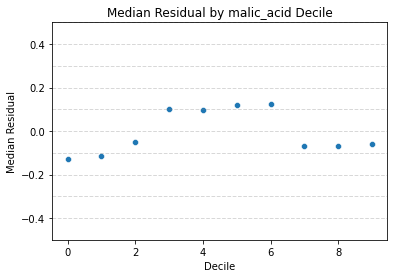

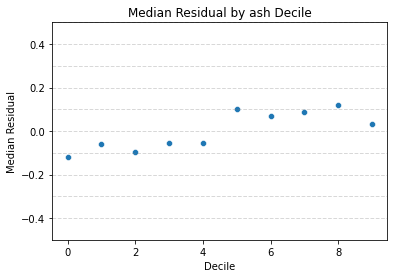

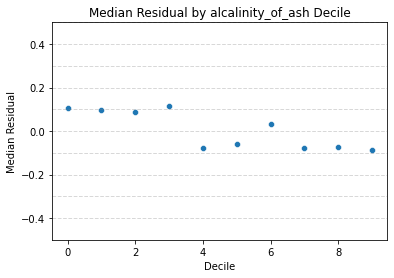

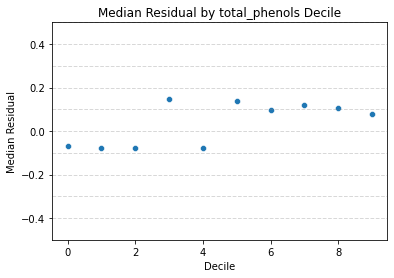

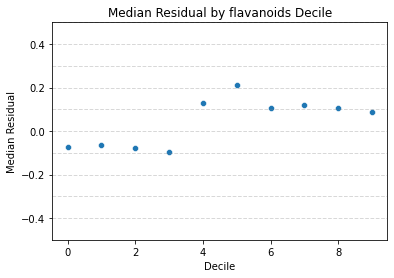

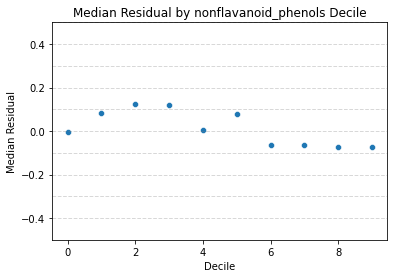

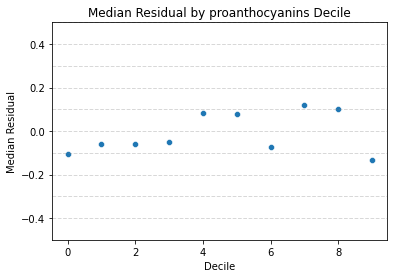

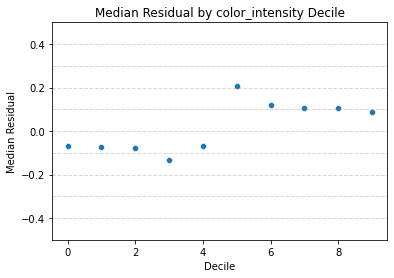

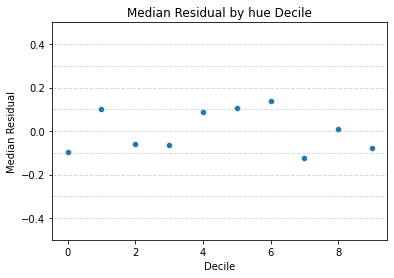

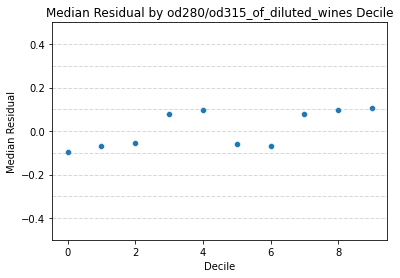

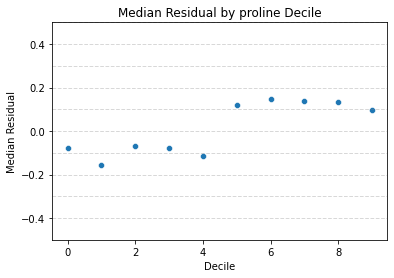

2021-08-18 12:43:34: Generating categorical feature plots


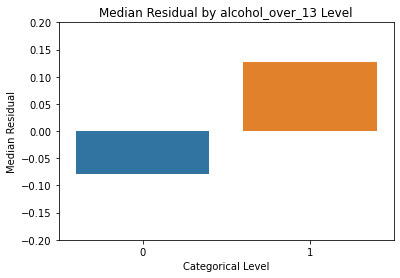

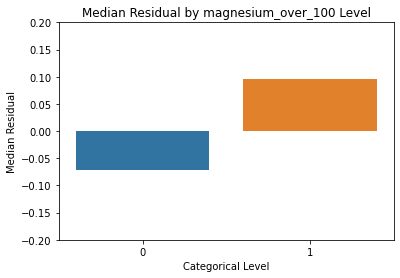

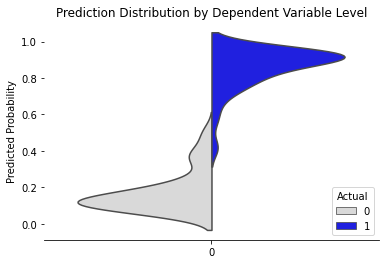

In [6]:
residual_analyzer.get_residual_summary_plots()

#### Note that residual output is available so you can perform other analysis

In [7]:
k_fold_residuals = residual_analyzer.get_kfold_residuals()
k_fold_residuals.head()

2021-08-18 12:43:34: Starting fold 1 of 5
2021-08-18 12:43:34: AUC of Fold 1: 0.994
2021-08-18 12:43:34: Starting fold 2 of 5
2021-08-18 12:43:34: AUC of Fold 2: 1.0
2021-08-18 12:43:34: Starting fold 3 of 5
2021-08-18 12:43:34: AUC of Fold 3: 0.994
2021-08-18 12:43:34: Starting fold 4 of 5
2021-08-18 12:43:34: AUC of Fold 4: 1.0
2021-08-18 12:43:34: Starting fold 5 of 5
2021-08-18 12:43:34: AUC of Fold 5: 1.0


,alcohol_over_13,malic_acid,ash,alcalinity_of_ash,magnesium_over_100,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,y,Predicted,Actual,Residual
0,1,1.71,2.43,15.6,1,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,0.071600,0,0.071600
1,1,1.78,2.14,11.2,0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,0.173826,0,0.173826
2,1,2.36,2.67,18.6,1,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,0.089523,0,0.089523
3,1,1.95,2.50,16.8,1,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,0.068512,0,0.068512
4,1,2.59,2.87,21.0,1,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,0.514849,0,0.514849
